In [1]:
import numpy as np
import scipy
from performance.parameters import mean_true_time, read_timing_pars
from performance.performance_plots import charge_resolution, time_resolution

from ctapipe.io import EventSource
from ctapipe.calib import CameraCalibrator
from ctapipe.image.extractor import deconvolution_parameters, adaptive_centroid, deconvolve, SlidingWindowMaxSum



In [2]:
directory = "/home/nieves/Notebooks/ctapipe_analysis/Data"  
simtel_url = directory + "/gamma_20deg_0deg_run1555___cta-prod6-paranal-2147m-Paranal-dark-bs5.0-10k-lfa64.simtel.zst"



In [3]:

def clip(x, lo=0.0, hi=np.inf):
    """Applies soft clipping to ±1 and then hard clipping to (lo, hi)."""
    return np.clip(x / (1.0 + np.abs(x)), lo, hi)

def time_profile_pdf_gen(std_dev: float):
    if std_dev == 0:
        return None
    return scipy.stats.norm(0.0, std_dev).pdf
    
def deconvolution(subarray, tel_id, upsampling=4, window_width=7, window_shift=3, apply_integration_correction=True, local_weight=0, effective_time_profile_std=2, neighbour_sum_clipping=5, leading_edge_timing=True, leading_edge_rel_descend_limit=0.05):

    sampling_rate_ghz = {
        subarray.tel[tel_id].camera.readout.sampling_rate.to_value("GHz")
    }

    deconvolution_pars = deconvolution_parameters(
            subarray.tel[tel_id].camera,
            upsampling,
            window_width,
            window_shift,
            leading_edge_timing,
            leading_edge_rel_descend_limit,
            time_profile_pdf_gen(effective_time_profile_std),
        )


    pole_zeros, gains, shifts, pz2ds = deconvolution_pars
    pz, gain, shift, pz2d = pole_zeros[0], gains[0], shifts[0], pz2ds[0]

    t_waveforms = deconvolve(waveforms, 0.0, upsampling, pz)
    
    return t_waveforms, pz, gain, shift, pz2d


        

In [4]:
true_image = []
image = []
peak_time = []
true_time = []

with EventSource(simtel_url) as source:

    subarray = source.subarray

    for event in source:

        for tel_id in subarray.get_tel_ids_for_type("MST_MST_FlashCam"): 
            
            true_pe = event.simulation.tel[tel_id].true_image            
            
            if true_pe is None:
                continue

            waveforms = event.r1.tel[tel_id].waveform
            broken_pixels = event.mon.tel[tel_id].pixel_status.hardware_failing_pixels[0]
            
            dec_waveforms, pz, gain, shift, pz2d = deconvolution(subarray, tel_id)
            dl1 = SlidingWindowMaxSum(subarray=subarray)(waveforms = dec_waveforms, tel_id=tel_id, selected_gain_channel=0, broken_pixels=broken_pixels, )
            true_t, true_std = mean_true_time(source, tel_id)

            true_image.append(true_pe)
            image.append(dl1.image)
            peak_time.append(dl1.peak_time)
            true_time.append(true_t)
            


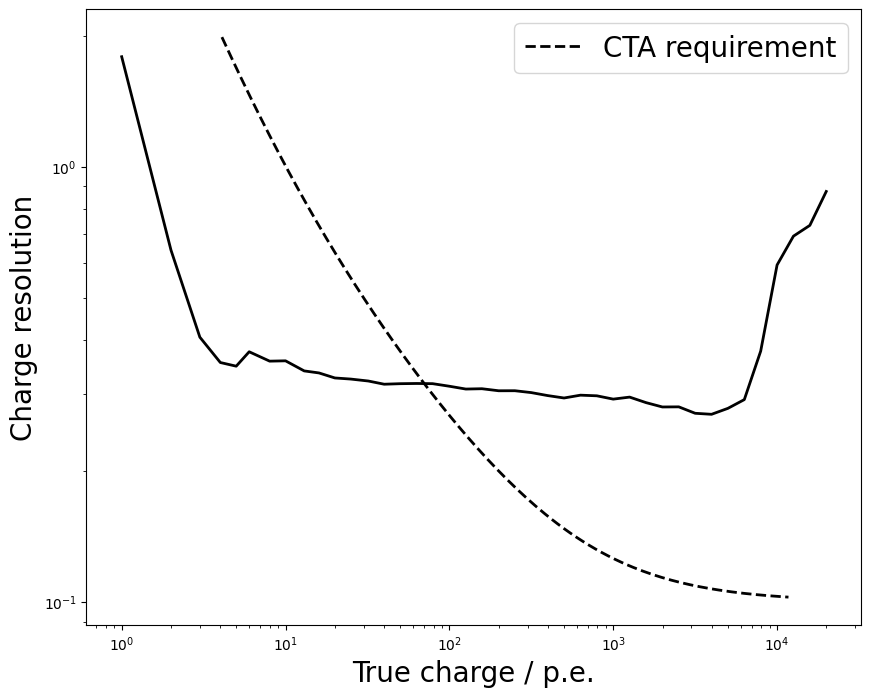

In [5]:
charge_resolution(0, 5, 50, np.array(true_image)[np.array(true_image)>0], np.array(image)[np.array(true_image)>0])
